<a href="https://colab.research.google.com/github/kiplangatkorir/Sentiment-Analysis-For-Electronic-Reviews/blob/main/sentiment_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving electronics_reviews.csv to electronics_reviews.csv


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Removed 9573 duplicate reviews. New dataset size: 426
Train-test overlap: 0
Class distribution in training set:
sentiment
negative    101
neutral     101
positive     96
Name: count, dtype: int64


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Performing zero-shot evaluation...
Zero-shot - Accuracy: 0.3438, Precision: 0.1146, Recall: 0.3333, F1: 0.1705
Zero-shot Confusion Matrix:
 [[22  0  0]
 [21  0  0]
 [21  0  0]]
Error analysis saved to /content/results/zero_shot_errors.csv

Performing 5-fold cross-validation...

Training Fold 1/5...
Fold 1 train-val overlap: 0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.064900,0.849319
2,0.683700,0.576127
3,0.554700,0.475513


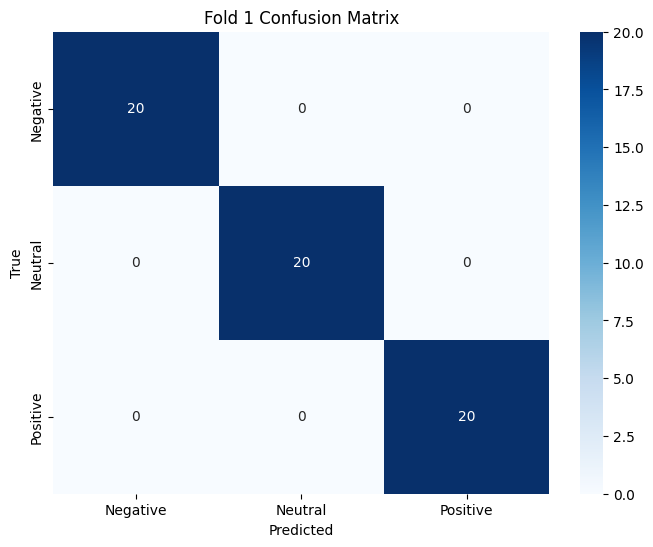


Training Fold 2/5...
Fold 2 train-val overlap: 0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.063800,0.872728
2,0.698800,0.583525
3,0.551500,0.470381


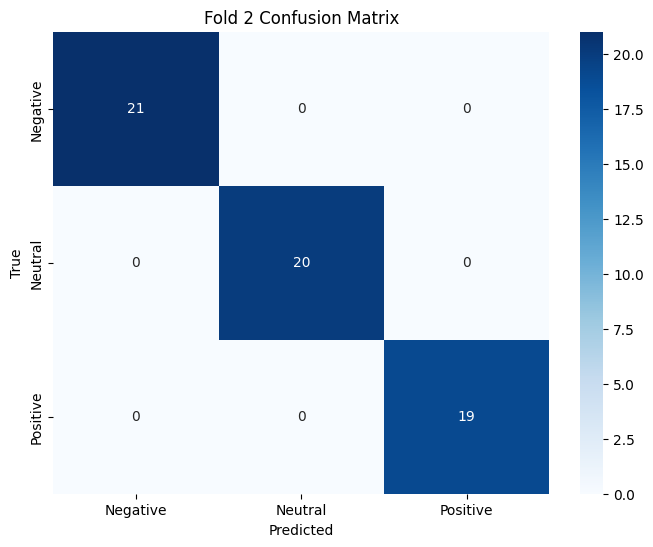


Training Fold 3/5...
Fold 3 train-val overlap: 0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.067000,0.878909
2,0.697800,0.591133
3,0.553700,0.479741


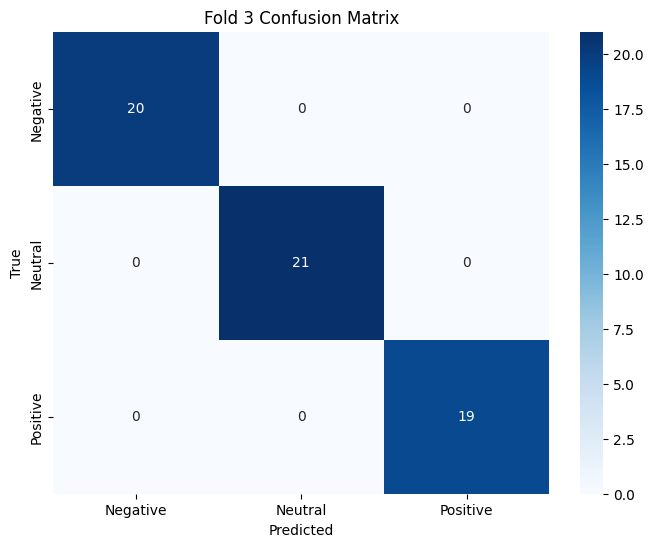


Training Fold 4/5...
Fold 4 train-val overlap: 0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.063900,0.870827
2,0.708400,0.588695
3,0.561500,0.477282


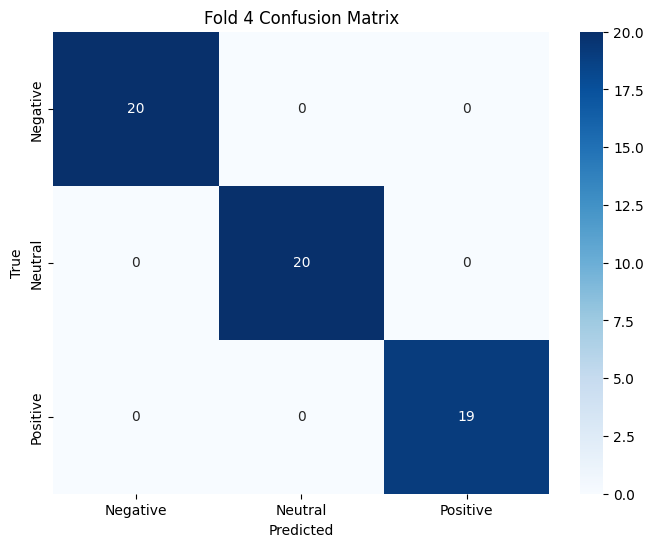


Training Fold 5/5...
Fold 5 train-val overlap: 0


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.055200,0.874564
2,0.710200,0.589472
3,0.574100,0.484099


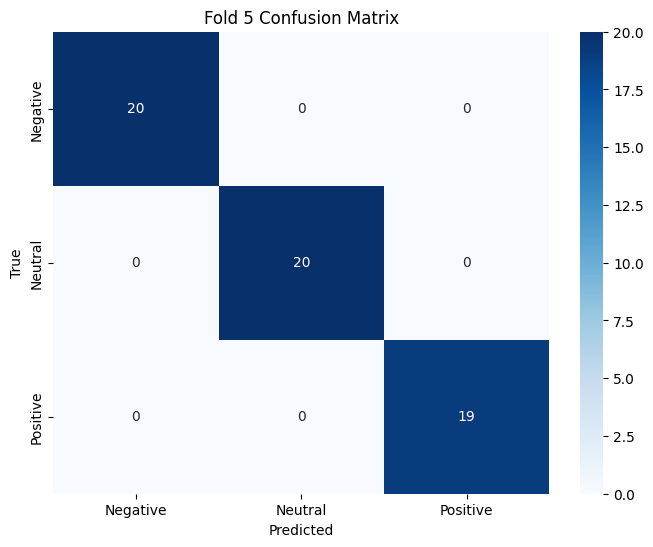


Cross-validation metrics saved to /content/results/cross_val_metrics.csv
Average Cross-Validation Metrics: {'accuracy': np.float64(1.0), 'precision': np.float64(1.0), 'recall': np.float64(1.0), 'f1': np.float64(1.0)}

Fine-tuning on full training data...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.050700,0.731144
2,0.638800,0.369486
3,0.352600,0.264225


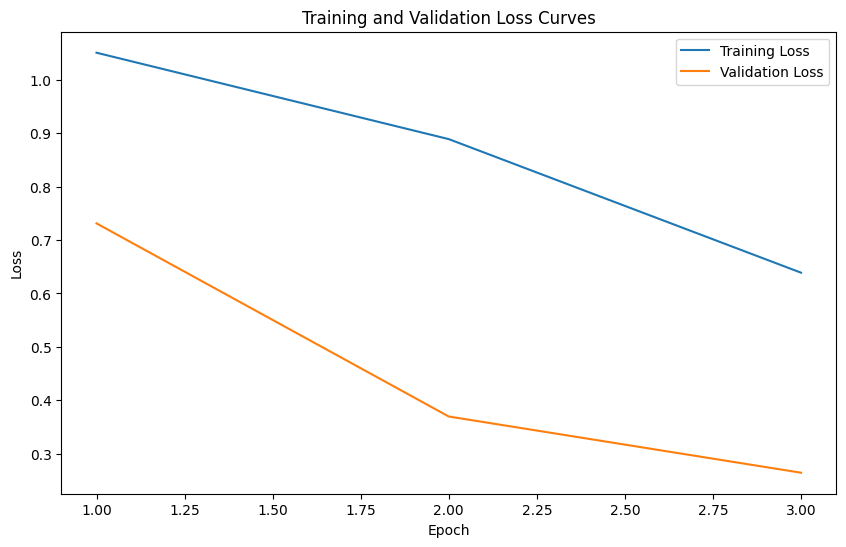


Evaluating fine-tuned model on test set...
Fine-tuned - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Fine-tuned Confusion Matrix:
 [[22  0  0]
 [ 0 21  0]
 [ 0  0 21]]
Performance comparison saved to /content/results/performance_comparison.csv


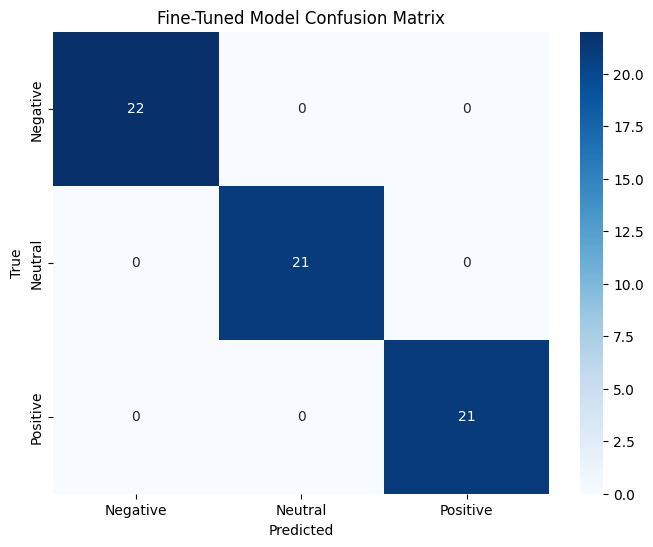

In [ ]:
# Install required libraries
!pip install transformers torch pandas scikit-learn matplotlib seaborn numpy

# Import libraries
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create directories for results
os.makedirs('/content/results', exist_ok=True)
os.makedirs('/content/logs', exist_ok=True)

# Load and preprocess the dataset
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data = data.dropna(subset=['review_text', 'sentiment'])
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    data['label'] = data['sentiment'].map(label_map)

    # Remove duplicates
    initial_len = len(data)
    data = data.drop_duplicates(subset=['review_text'], keep='first')
    print(f"Removed {initial_len - len(data)} duplicate reviews. New dataset size: {len(data)}")

    # Split data
    train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['label'])
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['label'])

    # Check for train-test overlap
    overlap = len(set(train_data['review_text']).intersection(set(test_data['review_text'])))
    print(f"Train-test overlap: {overlap}")
    if overlap > 0:
        print("Warning: Overlap detected. Re-splitting to ensure no overlap.")
        all_data = pd.concat([train_data, val_data, test_data])
        train_data, temp_data = train_test_split(all_data, test_size=0.3, random_state=43, stratify=all_data['label'])
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=43, stratify=temp_data['label'])
        print(f"New train-test overlap: {len(set(train_data['review_text']).intersection(set(test_data['review_text'])))}")

    return train_data, val_data, test_data

# Tokenize data
def tokenize_data(texts, tokenizer, max_length=128):
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    return encodings

# Custom Dataset class for Trainer
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Compute metrics
def compute_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    cm = confusion_matrix(true_labels, predictions)
    return accuracy, precision, recall, f1, cm

# Zero-shot evaluation
def zero_shot_evaluation(model, tokenizer, test_data, device):
    model.eval()
    test_encodings = tokenize_data(test_data['review_text'], tokenizer)
    test_labels = torch.tensor(test_data['label'].values)
    test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)
    test_loader = DataLoader(test_dataset, batch_size=16)

    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    accuracy, precision, recall, f1, cm = compute_metrics(true_labels, predictions)
    errors = test_data.iloc[[i for i, (pred, true) in enumerate(zip(predictions, true_labels)) if pred != true]].copy()
    errors['predicted_label'] = [pred for pred, true in zip(predictions, true_labels) if pred != true]
    label_map_reverse = {2: 'positive', 1: 'neutral', 0: 'negative'}
    errors['predicted_sentiment'] = errors['predicted_label'].map(label_map_reverse)
    return accuracy, precision, recall, f1, cm, errors

# Plot loss curves
def plot_loss_curves(log_history, output_path, num_epochs=3):
    train_loss = [log['loss'] for log in log_history if 'loss' in log]
    val_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
    steps_per_epoch = len(train_loss) // num_epochs
    train_loss_per_epoch = []
    for i in range(num_epochs):
        start_idx = i * steps_per_epoch
        end_idx = (i + 1) * steps_per_epoch
        epoch_loss = np.mean(train_loss[start_idx:end_idx])
        train_loss_per_epoch.append(epoch_loss)

    if len(val_loss) != num_epochs:
        print(f"Warning: Expected {num_epochs} validation losses, got {len(val_loss)}. Adjusting plot.")
        val_loss = val_loss[:num_epochs] + [val_loss[-1]] * (num_epochs - len(val_loss))

    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss_per_epoch, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.savefig(output_path)
    plt.show()

# K-Fold Cross-Validation
def k_fold_cross_validation(train_data, tokenizer, device, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_data['review_text'], train_data['label'])):
        print(f"\nTraining Fold {fold + 1}/{k}...")

        # Split data
        fold_train_data = train_data.iloc[train_idx]
        fold_val_data = train_data.iloc[val_idx]

        # Check for overlap within fold
        overlap = len(set(fold_train_data['review_text']).intersection(set(fold_val_data['review_text'])))
        print(f"Fold {fold + 1} train-val overlap: {overlap}")

        # Tokenize
        train_encodings = tokenize_data(fold_train_data['review_text'], tokenizer)
        val_encodings = tokenize_data(fold_val_data['review_text'], tokenizer)
        train_labels = fold_train_data['label'].values
        val_labels = fold_val_data['label'].values

        # Create datasets
        train_dataset = ReviewDataset(train_encodings, train_labels)
        val_dataset = ReviewDataset(val_encodings, val_labels)

        # Initialize model
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3).to(device)

        # Training arguments
        training_args = TrainingArguments(
            output_dir=f'/content/results/fold_{fold + 1}',
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            eval_strategy='epoch',
            save_strategy='epoch',
            logging_dir=f'/content/logs/fold_{fold + 1}',
            logging_steps=10,
            learning_rate=2e-5,
            load_best_model_at_end=True,
            metric_for_best_model='eval_loss'
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset
        )

        # Train
        trainer.train()

        # Evaluate on validation fold
        model.eval()
        val_encodings = tokenize_data(fold_val_data['review_text'], tokenizer)
        val_labels = torch.tensor(fold_val_data['label'].values)
        val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
        val_loader = DataLoader(val_dataset, batch_size=16)

        predictions = []
        true_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                predictions.extend(preds.cpu().tolist())
                true_labels.extend(labels.cpu().tolist())

        accuracy, precision, recall, f1, cm = compute_metrics(true_labels, predictions)
        fold_results.append({
            'fold': fold + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm.tolist()
        })

        # Save confusion matrix plot for this fold
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
        plt.title(f'Fold {fold + 1} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'/content/results/fold_{fold + 1}_confusion_matrix.png')
        plt.show()

    # Compute average metrics
    avg_metrics = {
        'accuracy': np.mean([r['accuracy'] for r in fold_results]),
        'precision': np.mean([r['precision'] for r in fold_results]),
        'recall': np.mean([r['recall'] for r in fold_results]),
        'f1': np.mean([r['f1'] for r in fold_results])
    }

    # Save cross-validation results
    pd.DataFrame(fold_results).to_csv('/content/results/cross_val_metrics.csv', index=False)
    print("\nCross-validation metrics saved to /content/results/cross_val_metrics.csv")
    print("Average Cross-Validation Metrics:", avg_metrics)

    return fold_results, avg_metrics

# Main execution
def main():
    # Initialize device, tokenizer, and model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    # Load dataset
    file_path = '/content/drive/MyDrive/electronics_reviews.csv'  # or '/content/electronics_reviews.csv' if uploaded
    train_data, val_data, test_data = load_and_preprocess_data(file_path)

    # Check class distribution
    print("Class distribution in training set:")
    print(train_data['sentiment'].value_counts())

    # Zero-shot evaluation
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3).to(device)
    print("\nPerforming zero-shot evaluation...")
    zero_shot_metrics = zero_shot_evaluation(model, tokenizer, test_data, device)
    zero_shot_accuracy, zero_shot_precision, zero_shot_recall, zero_shot_f1, zero_shot_cm, errors = zero_shot_metrics
    print(f"Zero-shot - Accuracy: {zero_shot_accuracy:.4f}, Precision: {zero_shot_precision:.4f}, Recall: {zero_shot_recall:.4f}, F1: {zero_shot_f1:.4f}")
    print("Zero-shot Confusion Matrix:\n", zero_shot_cm)

    # Save error analysis
    errors[['review_text', 'sentiment', 'predicted_sentiment']].to_csv('/content/results/zero_shot_errors.csv', index=False)
    print("Error analysis saved to /content/results/zero_shot_errors.csv")

    # Perform k-fold cross-validation
    print("\nPerforming 5-fold cross-validation...")
    fold_results, avg_cross_val_metrics = k_fold_cross_validation(train_data, tokenizer, device, k=5)

    # Fine-tune on full training data
    print("\nFine-tuning on full training data...")
    train_encodings = tokenize_data(train_data['review_text'], tokenizer)
    val_encodings = tokenize_data(val_data['review_text'], tokenizer)
    train_labels = train_data['label'].values
    val_labels = val_data['label'].values
    train_dataset = ReviewDataset(train_encodings, train_labels)
    val_dataset = ReviewDataset(val_encodings, val_labels)

    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3).to(device)
    training_args = TrainingArguments(
        output_dir='/content/results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        eval_strategy='epoch',
        save_strategy='epoch',
        logging_dir='/content/logs',
        logging_steps=10,
        learning_rate=2e-5,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        weight_decay=0.01  # Added regularization
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )

    trainer.train()

    # Save fine-tuned model
    model.save_pretrained('/content/results/fine_tuned_model')
    tokenizer.save_pretrained('/content/results/fine_tuned_model')

    # Plot and save loss curves
    plot_loss_curves(trainer.state.log_history, '/content/results/loss_curve.png', num_epochs=3)

    # Evaluate fine-tuned model on test set
    print("\nEvaluating fine-tuned model on test set...")
    fine_tuned_metrics = zero_shot_evaluation(model, tokenizer, test_data, device)
    fine_tuned_accuracy, fine_tuned_precision, fine_tuned_recall, fine_tuned_f1, fine_tuned_cm, _ = fine_tuned_metrics
    print(f"Fine-tuned - Accuracy: {fine_tuned_accuracy:.4f}, Precision: {fine_tuned_precision:.4f}, Recall: {fine_tuned_recall:.4f}, F1: {fine_tuned_f1:.4f}")
    print("Fine-tuned Confusion Matrix:\n", fine_tuned_cm)

    # Save performance comparison
    results = pd.DataFrame({
        'Model': ['Pretrained', 'Fine-Tuned', 'Cross-Validation (Avg)'],
        'Accuracy': [zero_shot_accuracy, fine_tuned_accuracy, avg_cross_val_metrics['accuracy']],
        'Precision': [zero_shot_precision, fine_tuned_precision, avg_cross_val_metrics['precision']],
        'Recall': [zero_shot_recall, fine_tuned_recall, avg_cross_val_metrics['recall']],
        'F1': [zero_shot_f1, fine_tuned_f1, avg_cross_val_metrics['f1']]
    })
    results.to_csv('/content/results/performance_comparison.csv', index=False)
    print("Performance comparison saved to /content/results/performance_comparison.csv")

    # Plot confusion matrix for fine-tuned model
    plt.figure(figsize=(8, 6))
    sns.heatmap(fine_tuned_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title('Fine-Tuned Model Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('/content/results/confusion_matrix.png')
    plt.show()

    # Copy results to Google Drive
    !cp -r /content/results /content/drive/MyDrive/sentiment_analysis_results
    print("Results copied to /content/drive/MyDrive/sentiment_analysis_results")

if __name__ == '__main__':
    main()